In [1]:
# ============================================================================
# BASELINE MODELING - Decision Tree (No Feature Engineering)
# ============================================================================

# Purpose: Get a baseline performance metric before feature engineering

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully!")

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
# ============================================================================
# STEP 1: Load Preprocessed Data
# ============================================================================

# Load the model-ready dataset (77 features, 124,097 matches)
df = pd.read_csv('../data/processed/matches_final_without_player_context.csv')

print(f"✓ Data loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nColumns ({len(df.columns)}):")
print(df.columns.tolist()[:20], "...")  # Show first 20 columns
print(f"\nTarget variable distribution:")
print(df['player1_won'].value_counts())
print(f"\nMissing values: {df.isnull().sum().sum()}")


✓ Data loaded successfully!
Shape: (124097, 77)

Columns (77):
['player1_rank', 'player1_rank_imputed', 'player1_ht', 'player1_age', 'player2_rank', 'player2_rank_imputed', 'player2_ht', 'player2_age', 'player1_won', 'draw_size', 'tourney_date', 'best_of', 'player1_hand_L', 'player1_hand_R', 'player1_hand_U', 'player2_hand_L', 'player2_hand_R', 'player2_hand_U', 'player1_entry_2) A', 'player1_entry_3)'] ...

Target variable distribution:
player1_won
1    62253
0    61844
Name: count, dtype: int64

Missing values: 0


In [ ]:
# ============================================================================
# STEP 2: Split Features and Target
# ============================================================================

# Separate features (X) and target (y)
# AXIS EXPLANATION: 
X = df.drop('player1_won', axis=1)
y = df['player1_won']

print(f"✓ Features and target separated")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nFeature columns: {X.columns.tolist()[:10]}...")  # Show first 10

X.info()

✓ Features and target separated
X shape: (124097, 76)
y shape: (124097,)

Feature columns: ['player1_rank', 'player1_rank_imputed', 'player1_ht', 'player1_age', 'player2_rank', 'player2_rank_imputed', 'player2_ht', 'player2_age', 'draw_size', 'tourney_date']...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124097 entries, 0 to 124096
Data columns (total 76 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   player1_rank          124097 non-null  float64
 1   player1_rank_imputed  124097 non-null  int64  
 2   player1_ht            124097 non-null  float64
 3   player1_age           124097 non-null  float64
 4   player2_rank          124097 non-null  float64
 5   player2_rank_imputed  124097 non-null  int64  
 6   player2_ht            124097 non-null  float64
 7   player2_age           124097 non-null  float64
 8   draw_size             124097 non-null  int64  
 9   tourney_date          124097 non-null  int64  
 10

## Train test validation Split 

* !!! I unknowning did this but technically if I just did a Train test split based on %age that would lead into all the dates of the matches getting messed up which could potentially lead to data leakage since we have training on future data potentially and testing on data before it ? So potentially model is learning future " trends or something " and there is data leakage !!!!

* #### Now what if I want to have those new trends in the recent data what should I do ? 
    * You still do the train test split based on the chronological order so there is no data leakage but then do this : 

    * Phase 1: Initial Training (2014-2022)
    * Phase 2: Validation (2023)
    * Phase 3: Test (2024)
    * Phase 4: RETRAIN for Production (2025)
        Now that 2024 is "past", include it in training!
    * Deploy to predict 2025 matches


In [ ]:
# ============================================================================
# STEP 3: Train/Validation/Test Split by Date
# ============================================================================

# Split based on tourney_date column
# Train: 2014-2022 (dates < 20230000)
# Validation: 2023 (20230000 <= dates < 20240000)
# Test: 2024 (dates >= 20240000)

# Split the dataframe first
train_df = df[df['tourney_date'] < 20230000].copy()
val_df = df[(df['tourney_date'] >= 20230000) & (df['tourney_date'] < 20240000)].copy()
test_df = df[df['tourney_date'] >= 20240000].copy()

# Now separate X and y for each split, dropping tourney_date from features
X_train = train_df.drop(['player1_won', 'tourney_date'], axis=1)
y_train = train_df['player1_won']

X_val = val_df.drop(['player1_won', 'tourney_date'], axis=1)
y_val = val_df['player1_won']

X_test = test_df.drop(['player1_won', 'tourney_date'], axis=1)
y_test = test_df['player1_won']

print(f"✓ Data split by tournament date")
print(f"\nTrain set (2014-2022): {X_train.shape[0]:,} matches ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Validation set (2023): {X_val.shape[0]:,} matches ({X_val.shape[0]/len(df)*100:.1f}%)")
print(f"Test set (2024):       {X_test.shape[0]:,} matches ({X_test.shape[0]/len(df)*100:.1f}%)")

print(f"\nFeatures per set: {X_train.shape[1]} (tourney_date dropped)")
print(f"\nClass balance in train set:")
print(y_train.value_counts(normalize=True))


✓ Data split by tournament date

Train set (2014-2022): 96,328 matches (77.6%)
Validation set (2023): 13,584 matches (10.9%)
Test set (2024):       14,185 matches (11.4%)

Features per set: 75 (tourney_date dropped)

Class balance in train set:
player1_won
1    0.501433
0    0.498567
Name: proportion, dtype: float64


In [ ]:
# ============================================================================
# STEP 4: Train Models
# ============================================================================

# Initialize Decision Tree with basic parameters
dt_model = DecisionTreeClassifier(
    max_depth=10,  
    min_samples_split=2,
    min_samples_leaf=1
)



# # Train the Decision tree model on TRAINING SET ONLY
# print("Training Decision Tree...")
# dt_model.fit(X_train, y_train)
# print("✓ Model trained successfully!")

# # Get predictions on all three sets
# y_train_pred = dt_model.predict(X_train)
# y_val_pred = dt_model.predict(X_val)
# y_test_pred = dt_model.predict(X_test)

# print("\n" + "="*70)
# print("BASELINE DECISION TREE PERFORMANCE")
# print("="*70)

#########################


# Initialize Random Forest with basic parameters
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42, # Because remember that we randomly choose features for each tree and a subset of the data for each tree
    max_depth=10,
    min_samples_split=50,
    min_samples_leaf=20,
    max_features= None
)




# print("training random forest...")
# rf_model.fit(X_train,y_train)
# print("✓ Model trained successfully!")

# #Get predictions on all three sets for Random Forest
# y_train_pred = rf_model.predict(X_train)
# y_val_pred = rf_model.predict(X_val)
# y_test_pred = rf_model.predict(X_test)

# print("Baseline Random Forest model trained successfully!")

# #########################


#intialize Logistic Regression

# Can use Logistic Regression for when the label is binary (0 or 1)

# Logistic Regression requires feature scaling
# Create and fit scaler on training data only
# *** Impotrant **** 
# Why Fit_transform on training data only?
# Because we want to learn the scaling parameters from the training data i.e the mean and std for each feature 
# We don't want to leak any information from the training data to the test data
# We want to evaluate the model on the test data as if it were new data so we only have std and mean from the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # *** Impotrant **** 
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✓ Features scaled using StandardScaler")
print(f"Original feature range example (player1_rank): {X_train['player1_rank'].min():.0f} to {X_train['player1_rank'].max():.0f}")
print(f"Scaled feature range: ~-3 to ~+3 (standardized)")

lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000
)

# # Train the model on SCALED training data
# print("\nTraining Logistic Regression...")
# lr_model.fit(X_train_scaled, y_train)
# print("✓ Model trained successfully!")

# # Get predictions on all three sets (scaled)
# y_train_pred = lr_model.predict(X_train_scaled)
# y_val_pred = lr_model.predict(X_val_scaled)
# y_test_pred = lr_model.predict(X_test_scaled)

# print("\n" + "="*70)
# print("LOGISTIC REGRESSION PERFORMANCE")
# print("="*70)


#########################


# Initialize XGBoost
xgb_model = XGBClassifier(
    n_estimators=200,        # Number of boosting rounds
    max_depth=8,             # Depth of each tree
    learning_rate=0.05,       # Step size shrinkage
    subsample=0.8,           # Fraction of samples per tree
    colsample_bytree=0.8,    # Fraction of features per tree
    random_state=42,
    eval_metric='logloss',   # Evaluation metric
    use_label_encoder=False  # Suppress warning
)

# Train the model
print("Training XGBoost...")
xgb_model.fit(X_train, y_train)
print("✓ Model trained successfully!")

# Get predictions on all sets
y_train_pred = xgb_model.predict(X_train)
y_val_pred = xgb_model.predict(X_val)
y_test_pred = xgb_model.predict(X_test)

print("\n" + "="*70)
print("XGBOOST PERFORMANCE")
print("="*70)


✓ Features scaled using StandardScaler
Original feature range example (player1_rank): 1 to 2258
Scaled feature range: ~-3 to ~+3 (standardized)
Training XGBoost...
✓ Model trained successfully!

XGBOOST PERFORMANCE


In [ ]:
# ============================================================================
# STEP 5: Evaluate Model Performance
# ============================================================================

def evaluate_model(y_true, y_pred, dataset_name):
    """Calculate and display evaluation metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"\n{dataset_name} Set Performance:")
    print(f"  Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    
    return accuracy, precision, recall, f1

# Evaluate on all sets
train_metrics = evaluate_model(y_train, y_train_pred, "Training")
val_metrics = evaluate_model(y_val, y_val_pred, "Validation")
test_metrics = evaluate_model(y_test, y_test_pred, "Test")

# Check for overfitting
print("\n" + "="*70)
print("OVERFITTING CHECK:")
print("="*70)
train_acc, val_acc, test_acc = train_metrics[0], val_metrics[0], test_metrics[0]
print(f"Train Accuracy:      {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy:       {test_acc:.4f}")
print(f"\nTrain-Val Gap:  {(train_acc - val_acc)*100:.2f}%")
print(f"Train-Test Gap: {(train_acc - test_acc)*100:.2f}%")

if train_acc - val_acc > 0.05:
    print("\n⚠️  WARNING: Significant overfitting detected (>5% gap)")
else:
    print("\n✓ Model generalization looks reasonable")



Training Set Performance:
  Accuracy:  0.7006 (70.06%)
  Precision: 0.7029
  Recall:    0.6979
  F1-Score:  0.7004

Validation Set Performance:
  Accuracy:  0.6357 (63.57%)
  Precision: 0.6391
  Recall:    0.6355
  F1-Score:  0.6373

Test Set Performance:
  Accuracy:  0.6293 (62.93%)
  Precision: 0.6305
  Recall:    0.6291
  F1-Score:  0.6298

OVERFITTING CHECK:
Train Accuracy:      0.7006
Validation Accuracy: 0.6357
Test Accuracy:       0.6293

Train-Val Gap:  6.50%
Train-Test Gap: 7.13%

⚠️  WARNING: Significant overfitting detected (>5% gap)



CONFUSION MATRIX (Validation Set)

[[4287 2455]
 [2494 4348]]

True Negatives (TN):  4,287 (Player1 lost, predicted lost)
False Positives (FP): 2,455 (Player1 lost, predicted won)
False Negatives (FN): 2,494 (Player1 won, predicted lost)
True Positives (TP):  4,348 (Player1 won, predicted won)


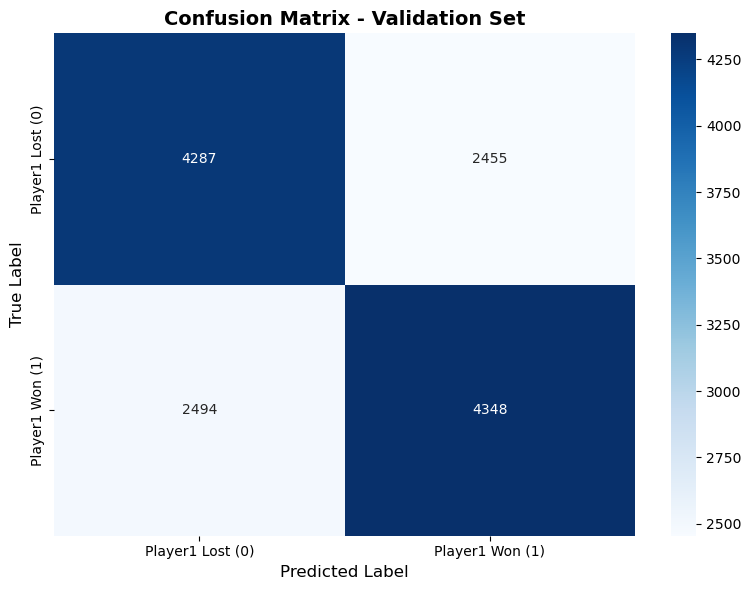


CLASSIFICATION REPORT (Validation Set)
              precision    recall  f1-score   support

Player1 Lost       0.63      0.64      0.63      6742
 Player1 Won       0.64      0.64      0.64      6842

    accuracy                           0.64     13584
   macro avg       0.64      0.64      0.64     13584
weighted avg       0.64      0.64      0.64     13584



In [ ]:
# ============================================================================
# STEP 6: Confusion Matrix and Classification Report
# ============================================================================

# Validation set confusion matrix
cm_val = confusion_matrix(y_val, y_val_pred)

print("\n" + "="*70)
print("CONFUSION MATRIX (Validation Set)")
print("="*70)
print(f"\n{cm_val}")
print(f"\nTrue Negatives (TN):  {cm_val[0,0]:,} (Player1 lost, predicted lost)")
print(f"False Positives (FP): {cm_val[0,1]:,} (Player1 lost, predicted won)")
print(f"False Negatives (FN): {cm_val[1,0]:,} (Player1 won, predicted lost)")
print(f"True Positives (TP):  {cm_val[1,1]:,} (Player1 won, predicted won)")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Player1 Lost (0)', 'Player1 Won (1)'],
            yticklabels=['Player1 Lost (0)', 'Player1 Won (1)'])
plt.title('Confusion Matrix - Validation Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Detailed classification report
print("\n" + "="*70)
print("CLASSIFICATION REPORT (Validation Set)")
print("="*70)
print(classification_report(y_val, y_val_pred, 
                          target_names=['Player1 Lost', 'Player1 Won']))


In [ ]:
# ============================================================================
# STEP 7: Feature Importance Analysis
# ============================================================================

# Get feature importances
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "="*70)
print("TOP 20 MOST IMPORTANT FEATURES")
print("="*70)
print(feature_importance.head(20).to_string(index=False))

# Visualize top 15 features
plt.figure(figsize=(10, 8))
top_15 = feature_importance.head(15)
plt.barh(range(len(top_15)), top_15['importance'], color='steelblue')
plt.yticks(range(len(top_15)), top_15['feature'])
plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Top 15 Most Important Features - Decision Tree', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Save feature importance to CSV
feature_importance.to_csv('../results/baseline_dt_feature_importance.csv', index=False)
print("\n✓ Feature importance saved to '../results/baseline_dt_feature_importance.csv'")


NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
# ============================================================================
# STEP 8: Summary and Next Steps
# ============================================================================

print("\n" + "="*70)
print("BASELINE MODEL SUMMARY")
print("="*70)

print(f"\n📊 MODEL: Decision Tree Classifier (No Feature Engineering)")
print(f"\n📁 DATASET:")
print(f"   - Total matches: {len(df):,}")
print(f"   - Features: {X.shape[1]}")
print(f"   - Train: {len(X_train):,} matches (2014-2022)")
print(f"   - Validation: {len(X_val):,} matches (2023)")
print(f"   - Test: {len(X_test):,} matches (2024)")

print(f"\n🎯 PERFORMANCE:")
print(f"   - Train Accuracy:      {train_metrics[0]:.4f} ({train_metrics[0]*100:.2f}%)")
print(f"   - Validation Accuracy: {val_metrics[0]:.4f} ({val_metrics[0]*100:.2f}%)")
print(f"   - Test Accuracy:       {test_metrics[0]:.4f} ({test_metrics[0]*100:.2f}%)")
print(f"   - Validation F1-Score: {val_metrics[3]:.4f}")

print(f"\n🔑 KEY INSIGHTS:")
print(f"   - This is the BASELINE before feature engineering")
print(f"   - Top features are mostly rank-related (player1_rank, player2_rank)")
print(f"   - Overfitting gap: {(train_metrics[0] - val_metrics[0])*100:.2f}%")

print(f"\n📝 NEXT STEPS:")
print(f"   1. Feature Engineering (rank_diff, age_diff, surface win rates)")
print(f"   2. Try other models (Random Forest, XGBoost, Logistic Regression)")
print(f"   3. Hyperparameter tuning to reduce overfitting")
print(f"   4. Compare baseline vs engineered feature performance")

print("\n" + "="*70)
